In [1]:
from IPython.core.display import display, HTML
from tensorflow import keras
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, preprocess_input, decode_predictions
from tensorflow.keras import layers, regularizers
import keras_tuner as kt
import tensorflow as tf
import os
import matplotlib.pyplot as plt


display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
titles_str = os.listdir('dataset/train/') # loading labels
num_classes = len(titles_str)

# Loading dataset

In [2]:
# dataset options
batch_size = 32
img_height = 224
img_width = 224

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/train',
    label_mode='categorical', color_mode='rgb', 
    batch_size=32, image_size=(224, 224), seed=42, validation_split=0.2, subset="training"
)


val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/train',
    label_mode='categorical', color_mode='rgb', 
    batch_size=32, image_size=(224, 224), seed=42, validation_split=0.2, subset="validation"
)

Found 2992 files belonging to 7 classes.
Using 2394 files for training.
Found 2992 files belonging to 7 classes.
Using 598 files for validation.


## Show the data

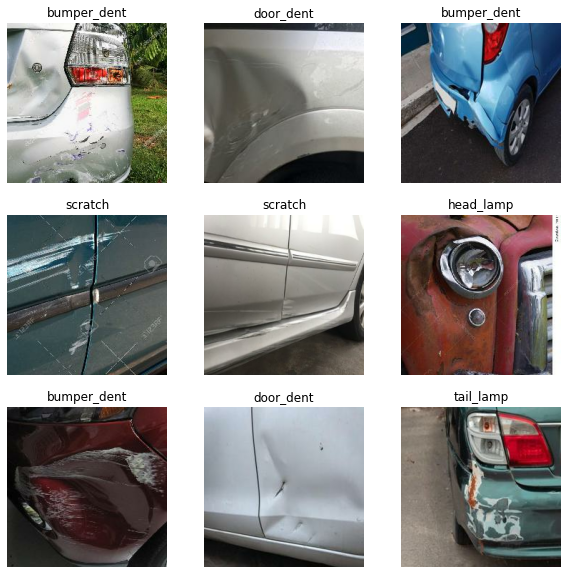

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  
    titles = tf.argmax(labels, axis=1).numpy().tolist()

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(titles_str[titles[i]])
        plt.axis("off")

## Resize, rescale, augment layers

In [4]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(img_height, img_width)
])

## Data preprocessing functions

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):

    # Resize and rescale all datasets
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
  
    # preprocess for VGG16
    ds = ds.map(lambda x, y: (preprocess_input(x), y), 
              num_parallel_calls=AUTOTUNE)

    # Use buffered prefecting on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)

# apply prepare funtion to datasets
train_dataset = prepare(train_dataset, shuffle=True, augment=True)
val_dataset = prepare(val_dataset)

# Model definition

In [6]:
def model_builder(hp):
    model = keras.Sequential()
    
    # load ResNet with weights
    resnet = ResNet152V2(include_top=False)
    
    # freeze ResNet layers
    for layer in resnet.layers:
        layer.trainable = False
    
    model.add(resnet)
    model.add(layers.GlobalAveragePooling2D())
    
    # dropout search layer 1
    hp_dropouts1 = hp.Float('dropout_1', min_value=0.0, max_value=0.9, step=0.1)
    model.add(layers.Dropout(hp_dropouts1))
    
    model.add(layers.Flatten())
    model.add(layers.BatchNormalization())
    
    # num params search in first dense layer
    hp_units = hp.Int('units', min_value=64, max_value=4096, step=32)
    model.add(layers.Dense(units=hp_units, activation='relu'))
    
    # dropout search layer 2
    hp_dropouts2 = hp.Float('dropout_2', min_value=0.0, max_value=0.9, step=0.1)
    model.add(layers.Dropout(hp_dropouts2))
    
    model.add(layers.Dense(num_classes))
    
    # learning rate search
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    

    return model

In [7]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=500,
                     factor=3,
                     directory='model',
                     project_name='pcd-resnet152v2')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
Best dropout 1 is {best_hps.get('dropout1')} and best dropout2 is {best_hps.get('dropout2')}
""")

Trial 93 Complete [00h 01m 50s]
val_accuracy: 0.5969899892807007

Best val_accuracy So Far: 0.7809364795684814
Total elapsed time: 02h 56m 26s

Search: Running Trial #94

Hyperparameter    |Value             |Best Value So Far 
dropout_1         |0.3               |0.3               
units             |1664              |3648              
dropout_2         |0.1               |0.3               
learning_rate     |0.001             |0.0001            
tuner/epochs      |3                 |3                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |5                 |5                 
tuner/round       |0                 |0                 

Epoch 1/3
75/75 [==============================] - 42s 391ms/step - loss: 1.6283 - accuracy: 0.5660 - val_loss: 0.8875 - val_accuracy: 0.7324
Epoch 2/3


KeyboardInterrupt: 

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_dataset, epochs=best_epoch, validation_data=val_dataset)

In [ ]:
# hypermodel.save('model/hypermodel')

In [ ]:
hypermodel.save('model/hypermodel-resnet152v2')